In [1]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [2]:
import os
import json
import glob
import pandas as pd
from pathlib import Path

def load_all_model_results():
    """Load all model fit results from the model_fits directory"""
    results = []
    
    # Find all JSON files in model_fits directory
    json_files = glob.glob("model_fits/**/*.json", recursive=True)

    
    
    for file_path in json_files:
        # if in filename "all_all", skip
        if "all" in os.path.basename(file_path):
            continue
        try:
            with open(file_path, 'r') as f:
                result = json.load(f)
            
            # Extract participant ID and model type from filename if not in data
            filename = os.path.basename(file_path)
            parts = filename.replace('.json', '').split('_')
            #print(parts)
            if 'participantID' not in result:
                result['participantID'] = parts[0]

            
            result['modelType'] = parts[1]+"_"+parts[3]
            
            if parts[2]!="LapseFree":
                #print("Lapse fixed model, skipping")
                continue
            

            results.append(result)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return results

# Load all results
all_results = load_all_model_results()
print(f"Loaded {len(all_results)} model fit results")

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(all_results)
print(f"Participants: {sorted(df_results['participantID'].unique())}")
print(f"Models: {sorted(df_results['modelType'].unique())}")



Loaded 132 model fit results
Participants: ['as', 'dt', 'hh', 'ip', 'ln1', 'ln2', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']
Models: ['fusionOnlyLogNorm_sharedPrior', 'fusionOnly_sharedPrior', 'gaussian_sharedPrior', 'logLinearMismatch_sharedPrior', 'lognorm_sharedPrior', 'probabilityMatchingLogNorm_sharedPrior', 'probabilityMatching_sharedPrior', 'selection_sharedPrior', 'switchingFree_sharedPrior', 'switchingWithConflict_sharedPrior', 'switching_sharedPrior']


In [3]:
def rename_model(best_models_df, old_name, new_name):
    """Rename a model name across all relevant DataFrames and variables."""
    # Rename in df_results
    best_models_df['modelType'] = best_models_df['modelType'].replace(old_name, new_name)
    
    # Rename in best_models_df
    best_models_df['best_model'] = best_models_df['best_model'].replace(old_name, new_name)
    
    # Rename in comparison_table_df
    comparison_table_df.columns = comparison_table_df.columns.map(
        lambda col: col if col[1] != old_name else (col[0], new_name)
    )
    
    # Rename in delta_aic_table
    delta_aic_table.columns = delta_aic_table.columns.str.replace(old_name, new_name)
    
    # Rename in ll_table
    ll_table.columns = ll_table.columns.str.replace(old_name, new_name)
    
    # Rename in simple_table
    simple_table.columns = simple_table.columns.str.replace(old_name, new_name)
    
    # Update participant_best_models
    global participant_best_models
    participant_best_models = [
        new_name if model == old_name else model for model in participant_best_models
    ]
    
    # Update ll_best_models
    global ll_best_models
    ll_best_models = [
        new_name if model == old_name else model for model in ll_best_models
    ]
    
    # Print confirmation
    print(f"Model name '{old_name}' has been renamed to '{new_name}'")


In [4]:
# Find best model for each participant (lowest AIC)
def find_best_models(df_results):
    """Find the best fitting model for each participant based on AIC"""
    best_models = []
    
    for participant in df_results['participantID'].unique():
        participant_data = df_results[df_results['participantID'] == participant]
        
        if len(participant_data) > 0:
            # Find model with lowest AIC
            best_idx = participant_data['AIC'].idxmin()
            best_model = participant_data.loc[best_idx]

            # delta AIC and BIC compared to the best model
            for _, row in participant_data.iterrows():
                if row['modelType'] != best_model['modelType']:
                    delta_AIC = row['AIC'] - best_model['AIC']
                    delta_BIC = row['BIC'] - best_model['BIC']
                    print(f"Participant {participant}, Model {row['modelType']} vs Best Model {best_model['modelType']}: ΔAIC={delta_AIC:.2f}, ΔBIC={delta_BIC:.2f}")
            
            best_models.append({
                'participantID': participant,
                'best_model': best_model['modelType'],
                'AIC': best_model['AIC'],
                'BIC': best_model['BIC'],
                'logLikelihood': best_model['logLikelihood'],
                'delta_AIC': delta_AIC,
                'delta_BIC': delta_BIC
            })
    
    return pd.DataFrame(best_models)

# Find best models
best_models_df = find_best_models(df_results)
print("\nBest Model for Each Participant (based on AIC):")
print("=" * 60)
print(best_models_df.round(3))

# Model performance summary
print(f"\nModel Performance Summary:")
print("=" * 40)
model_counts = best_models_df['best_model'].value_counts()
for model, count in model_counts.items():
    percentage = (count / len(best_models_df)) * 100
    print(f"{model}: {count} participants ({percentage:.1f}%)")

Participant sx, Model switchingFree_sharedPrior vs Best Model switchingWithConflict_sharedPrior: ΔAIC=5.59, ΔBIC=-2.53
Participant sx, Model lognorm_sharedPrior vs Best Model switchingWithConflict_sharedPrior: ΔAIC=19.59, ΔBIC=7.16
Participant sx, Model logLinearMismatch_sharedPrior vs Best Model switchingWithConflict_sharedPrior: ΔAIC=37.70, ΔBIC=25.27
Participant sx, Model fusionOnly_sharedPrior vs Best Model switchingWithConflict_sharedPrior: ΔAIC=16.78, ΔBIC=-0.25
Participant sx, Model fusionOnlyLogNorm_sharedPrior vs Best Model switchingWithConflict_sharedPrior: ΔAIC=14.16, ΔBIC=-2.58
Participant sx, Model selection_sharedPrior vs Best Model switchingWithConflict_sharedPrior: ΔAIC=17.54, ΔBIC=5.11
Participant sx, Model switching_sharedPrior vs Best Model switchingWithConflict_sharedPrior: ΔAIC=31.52, ΔBIC=27.26
Participant sx, Model probabilityMatching_sharedPrior vs Best Model switchingWithConflict_sharedPrior: ΔAIC=15.76, ΔBIC=3.33
Participant sx, Model gaussian_sharedPrior vs B

In [5]:
# Rename models in df_results BEFORE creating any tables
df_results['modelType'] = df_results['modelType'].replace({
    'probabilityMatchingLogNorm_sharedPrior': 'prob-Matching-Log',
    'probabilityMatchingLogNorm': 'prob-Matching',
    'probabilityMatching_sharedPrior': 'prob-Matching-Gauss',
    'switchingFree_sharedPrior': 'Free Switching',
    'switching_sharedPrior': 'Noise Dep. Switching',
    'switchingWithConflict_sharedPrior': 'Noise Dep. Switching + Conflict',
    'fusionOnly_sharedPrior': 'Fusion Only',
    'fusionOnlyLogNorm_sharedPrior': 'Fusion Only-Log',
    'lognorm_sharedPrior': 'Log-Space Causal',
    'gaussian_sharedPrior': 'Gaussian-Space Causal',
    'lognorm_contextualPrior': 'Log-Space Causal + Context'
})

df_results["nParameters"] = [len(params) for params in df_results["fittedParams"]]
df_results["AIC_recalculated"] = 2 * df_results["nParameters"] - 2 * df_results["logLikelihood"]

print("Model names updated successfully!")
print(f"Current model types: {sorted(df_results['modelType'].unique())}")

Model names updated successfully!
Current model types: ['Free Switching', 'Fusion Only', 'Fusion Only-Log', 'Gaussian-Space Causal', 'Log-Space Causal', 'Noise Dep. Switching', 'Noise Dep. Switching + Conflict', 'logLinearMismatch_sharedPrior', 'prob-Matching-Gauss', 'prob-Matching-Log', 'selection_sharedPrior']


In [6]:
df_results

,participantID,modelType,fittedParams,AIC,BIC,logLikelihood,n_conditions,nParameters,AIC_recalculated
0,sx,Free Switching,"[0.0010000761032104288, 0.0684153325366973, 0....",2141.076250,2175.526452,-1062.538125,548,8,2141.076250
1,sx,Log-Space Causal,"[0.010827709444374759, 0.2970975477012458, 0.3...",2155.071194,2185.215121,-1070.535597,548,7,2155.071194
2,sx,logLinearMismatch_sharedPrior,"[0.032859806000393364, 0.2476851209303061, 0.2...",2173.184572,2203.328499,-1079.592286,548,7,2173.184572
3,sx,Fusion Only,"[0.022887993079794316, 0.153758934479332, 0.16...",2152.265325,2177.811330,-1070.132662,522,6,2152.265325
4,sx,Fusion Only-Log,"[0.001000086629595498, 0.30521380870952497, 0....",2149.645484,2175.483135,-1068.822742,548,6,2149.645484
...,...,...,...,...,...,...,...,...,...
127,ip,Noise Dep. Switching,"[0.27314112638435994, 0.10224985842073724, 0.2...",2463.951618,2501.756200,-1222.975809,493,9,2463.951618
128,ip,Gaussian-Space Causal,"[0.18700045776458166, 0.13105093065150072, 0.2...",2473.681472,2503.085036,-1229.840736,493,7,2473.681472
129,ip,logLinearMismatch_sharedPrior,"[0.1911488932291989, 0.19594522194790084, 0.89...",2412.412694,2441.816258,-1199.206347,493,7,2412.412694
130,ip,Fusion Only-Log,"[0.13788956496247556, 0.23585898570927377, 1.1...",2404.078456,2429.281511,-1196.039228,493,6,2404.078456


Participants sorted by sum of delta_AIC across all models (lowest to highest):
Delta_AIC sums: {'dt': 77.82828872301525, 'as': 92.9453250988804, 'hh': 100.89675698814494, 'ln1': 158.0414710952939, 'oy': 163.40717437960757, 'sx': 227.31471590370074, 'ml': 231.22019264901883, 'ln2': 235.93486772652568, 'qs': 272.3854401312615, 'mt': 291.1728367499195, 'ip': 391.44083990792114, 'mh': 557.2653895160261}


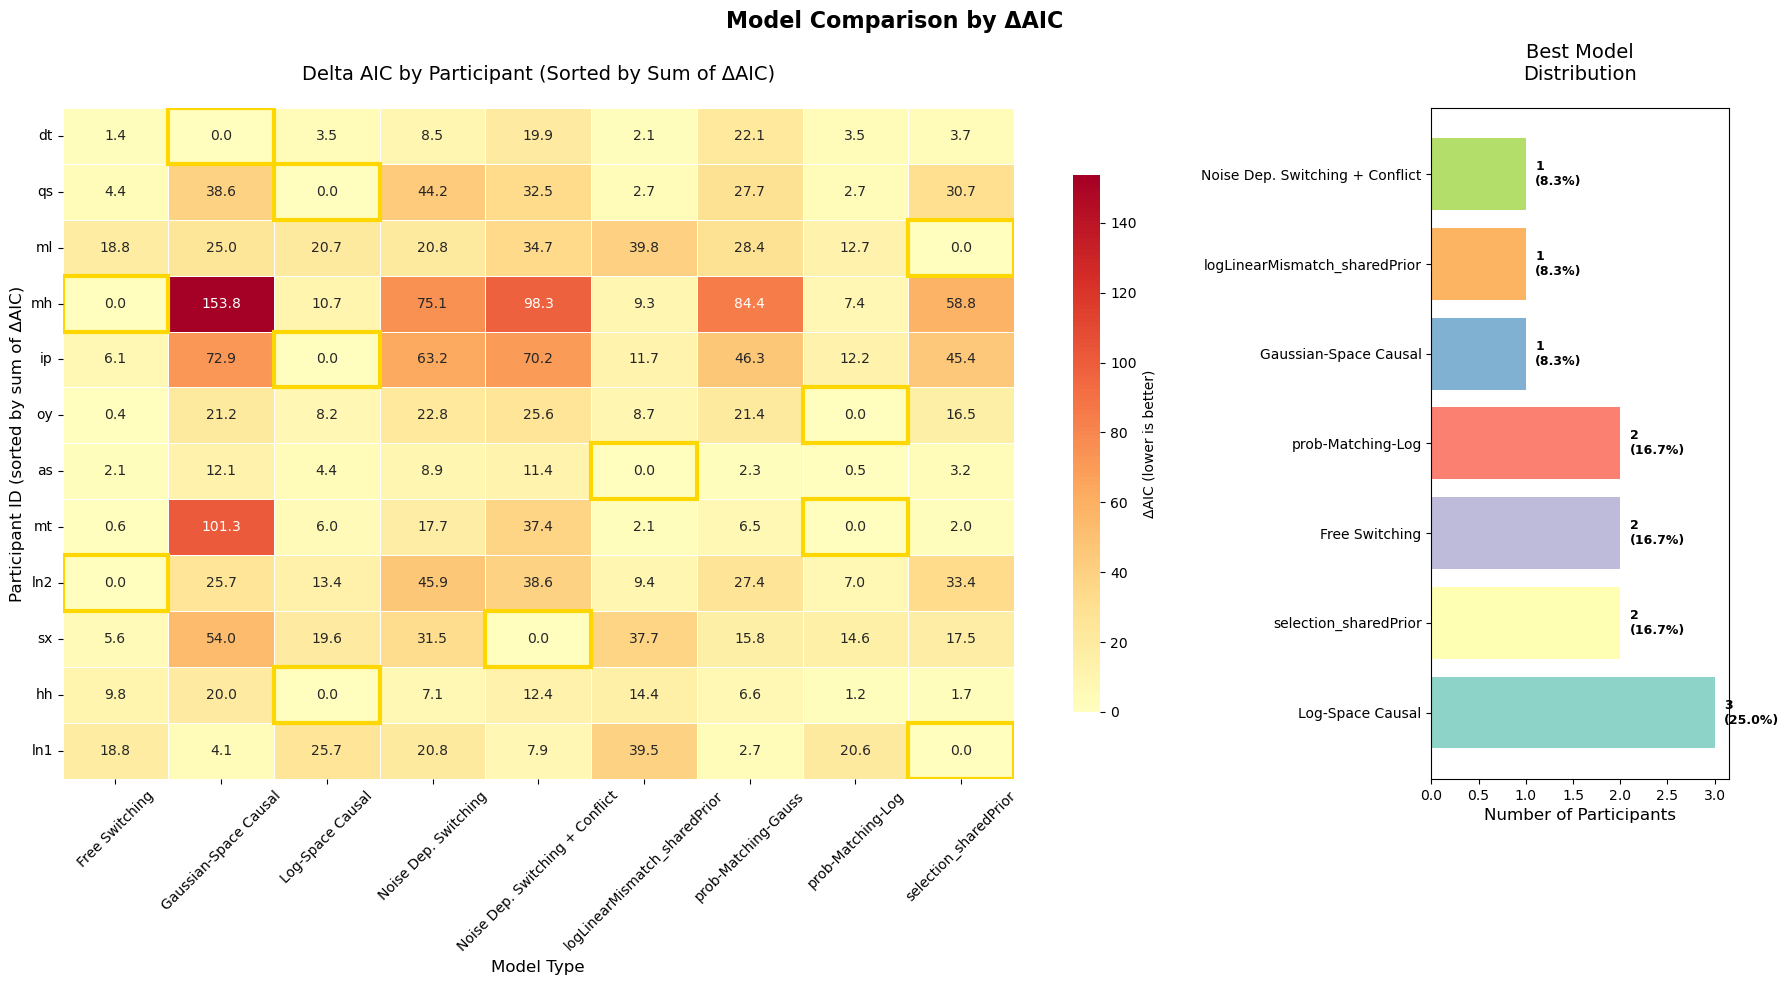


PARTICIPANT RANKING TABLE (sorted by sum of ΔAIC across all models)
Rank Participant  Sum Δ      Best Model         Min Δ      Performance    
------------------------------------------------------------------------------------------
1    dt           23041.9    Gaussian-Space Causal 2553.0     Poor fit       
2    qs           22680.0    Log-Space Causal   2499.6     Poor fit       
3    ml           22660.8    selection_sharedPrior 2495.5     Poor fit       
4    mh           22331.4    Free Switching     2426.0     Poor fit       
5    ip           21934.8    Log-Space Causal   2400.8     Poor fit       
6    oy           21069.2    prob-Matching-Log  2327.2     Poor fit       
7    as           20357.4    logLinearMismatch_sharedPrior 2257.0     Poor fit       
8    mt           20018.2    prob-Matching-Log  2204.9     Poor fit       
9    ln2          19731.2    Free Switching     2170.1     Poor fit       
10   sx           19415.7    Noise Dep. Switching + Conflict 2135.5     P

In [7]:
# Calculate delta_AIC for each model relative to the best model per participant
df_results['delta_AIC'] = df_results.groupby('participantID')['AIC'].transform(lambda x: x - x.min())

# Sort participants by sum of delta_AIC across all models (lower sum = better overall performance)
participant_delta_sums = df_results.groupby('participantID')['delta_AIC'].sum().sort_values()
sorted_participants = participant_delta_sums.index.tolist()
print("Participants sorted by sum of delta_AIC across all models (lowest to highest):")
print(f"Delta_AIC sums: {participant_delta_sums.to_dict()}")

import matplotlib.pyplot as plt
import seaborn as sns

# Create enhanced table-style visualization
def plot_sorted_model_comparison_table(df_results,compBase='AIC', notFusion=1):
    removeModels= ["Fusion Only", "Fusion Only-Log"]
    df_results = df_results[~df_results['modelType'].isin(removeModels)]
    """Create a comprehensive table plot with participants sorted by sum of delta_AIC"""
    
    # Calculate delta_AIC for each model relative to the best model
    df_results['delta_AIC'] = df_results.groupby('participantID')[compBase].transform(lambda x: x - x.min())
    
    # Sort participants by sum of delta_AIC across all models
    participant_delta_sums = df_results.groupby('participantID')['logLikelihood'].sum().sort_values()
    sorted_participants = participant_delta_sums.index.tolist()
    
    # Create the pivot table with sorted participants
    df_delta_aic = df_results.pivot(index='participantID', columns='modelType', values='delta_AIC')
    df_delta_aic = df_delta_aic.reindex(sorted_participants)
    
    # Find best model for each participant
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data[compBase].idxmin(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle(f'Model Comparison by Δ{compBase}', fontsize=16, fontweight='bold')
    
    # Main heatmap with delta_AIC values
    sns.heatmap(df_delta_aic, 
                annot=True, 
                fmt='.1f', 
                cmap='RdYlBu_r', 
                center=0,
                ax=ax1,
                cbar_kws={'label': f'Δ{compBase} (lower is better)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title(f'Delta {compBase} by Participant (Sorted by Sum of Δ{compBase})', fontsize=14, pad=20)
    ax1.set_ylabel(f'Participant ID (sorted by sum of Δ{compBase})', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_delta_aic.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a star or border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='gold', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Best model summary
    best_model_counts = pd.Series(best_models).value_counts()
    colors = plt.cm.Set3(range(len(best_model_counts)))
    
    bars = ax2.barh(range(len(best_model_counts)), best_model_counts.values, color=colors)
    ax2.set_yticks(range(len(best_model_counts)))
    ax2.set_yticklabels(best_model_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Participants', fontsize=12)
    ax2.set_title('Best Model\nDistribution', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, best_model_counts.values)):
        percentage = (count / len(sorted_participants)) * 100
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{count}\n({percentage:.1f}%)', 
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    # # Add legend explaining the gold borders
    # ax1.text(0.02, 0.98, '★ Gold border = Best model for participant', 
    #          transform=ax1.transAxes, fontsize=10, 
    #          bbox=dict(boxstyle='round,pad=0.3', facecolor='gold', alpha=0.7),
    #          verticalalignment='top')
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print(f"PARTICIPANT RANKING TABLE (sorted by sum of Δ{compBase} across all models)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Sum Δ':<10} {'Best Model':<18} {'Min Δ ':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data[compBase].sum()
        min_delta_aic = participant_data[compBase].min()
        best_model = participant_data.loc[participant_data[compBase].idxmin(), 'modelType']
        
        if sum_delta_aic <= 5:
            performance = "Excellent fit"
        elif sum_delta_aic <= 15:
            performance = "Good fit"
        elif sum_delta_aic <= 30:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {sum_delta_aic:<10.1f} {best_model:<18} {min_delta_aic:<10.1f} {performance:<15}")
    
    return df_delta_aic, best_models, participant_delta_sums

# Create the enhanced visualization
delta_aic_table, participant_best_models, delta_sums = plot_sorted_model_comparison_table(df_results,compBase='AIC', notFusion=1)

In [8]:
# Simple Model Comparison Table with Log Likelihoods
def create_simple_comparison_table(df_results):
    """Create a simple comparison table focused on log likelihoods"""
    
    # Pivot to show log likelihoods for each participant-model combination
    log_likelihood_table = df_results.pivot(
        index='participantID', 
        columns='modelType', 
        values='logLikelihood'
    )
    
    # Sort participants by ID for consistent ordering
    log_likelihood_table = log_likelihood_table.sort_index()
    
    return log_likelihood_table

# Create the simple comparison table
simple_table = create_simple_comparison_table(df_results)

print("Model Comparison Table - Log Likelihoods")
print("=" * 80)
print("Higher values indicate better fit")
print("=" * 80)
print()

# Display with better formatting
pd.set_option('display.float_format', '{:.2f}'.format)
display(simple_table)

# Reset display options
pd.reset_option('display.float_format')

Model Comparison Table - Log Likelihoods
Higher values indicate better fit



modelType,Free Switching,Fusion Only,Fusion Only-Log,Gaussian-Space Causal,Log-Space Causal,Noise Dep. Switching,Noise Dep. Switching + Conflict,logLinearMismatch_sharedPrior,prob-Matching-Gauss,prob-Matching-Log,selection_sharedPrior
participantID,,,,,,,,,,,
as,-1121.52,-1125.67,-1120.39,-1127.53,-1123.66,-1123.94,-1124.17,-1121.48,-1122.61,-1121.73,-1123.09
dt,-1269.22,-1276.67,-1270.81,-1269.50,-1271.26,-1271.77,-1276.47,-1270.57,-1280.57,-1271.26,-1271.33
hh,-595.84,-591.93,-591.45,-601.93,-591.92,-593.48,-595.13,-599.14,-595.23,-592.53,-592.78
ip,-1195.44,-1224.45,-1196.04,-1229.84,-1193.38,-1222.98,-1225.48,-1199.21,-1216.51,-1199.50,-1216.08
ln1,-577.67,-572.00,-577.52,-571.35,-582.12,-577.71,-570.25,-589.04,-570.65,-579.60,-569.29
ln2,-1077.03,-1095.45,-1080.21,-1090.87,-1084.72,-1098.99,-1094.32,-1082.71,-1091.72,-1081.53,-1094.72
mh,-1204.98,-1236.14,-1207.63,-1282.86,-1211.34,-1241.55,-1252.11,-1210.61,-1248.16,-1209.68,-1235.39
ml,-1249.19,-1249.52,-1249.18,-1253.29,-1251.14,-1249.15,-1255.13,-1260.67,-1254.97,-1247.11,-1240.77
mt,-1094.78,-1108.79,-1091.83,-1146.14,-1098.47,-1102.33,-1111.17,-1096.55,-1098.72,-1095.47,-1096.48


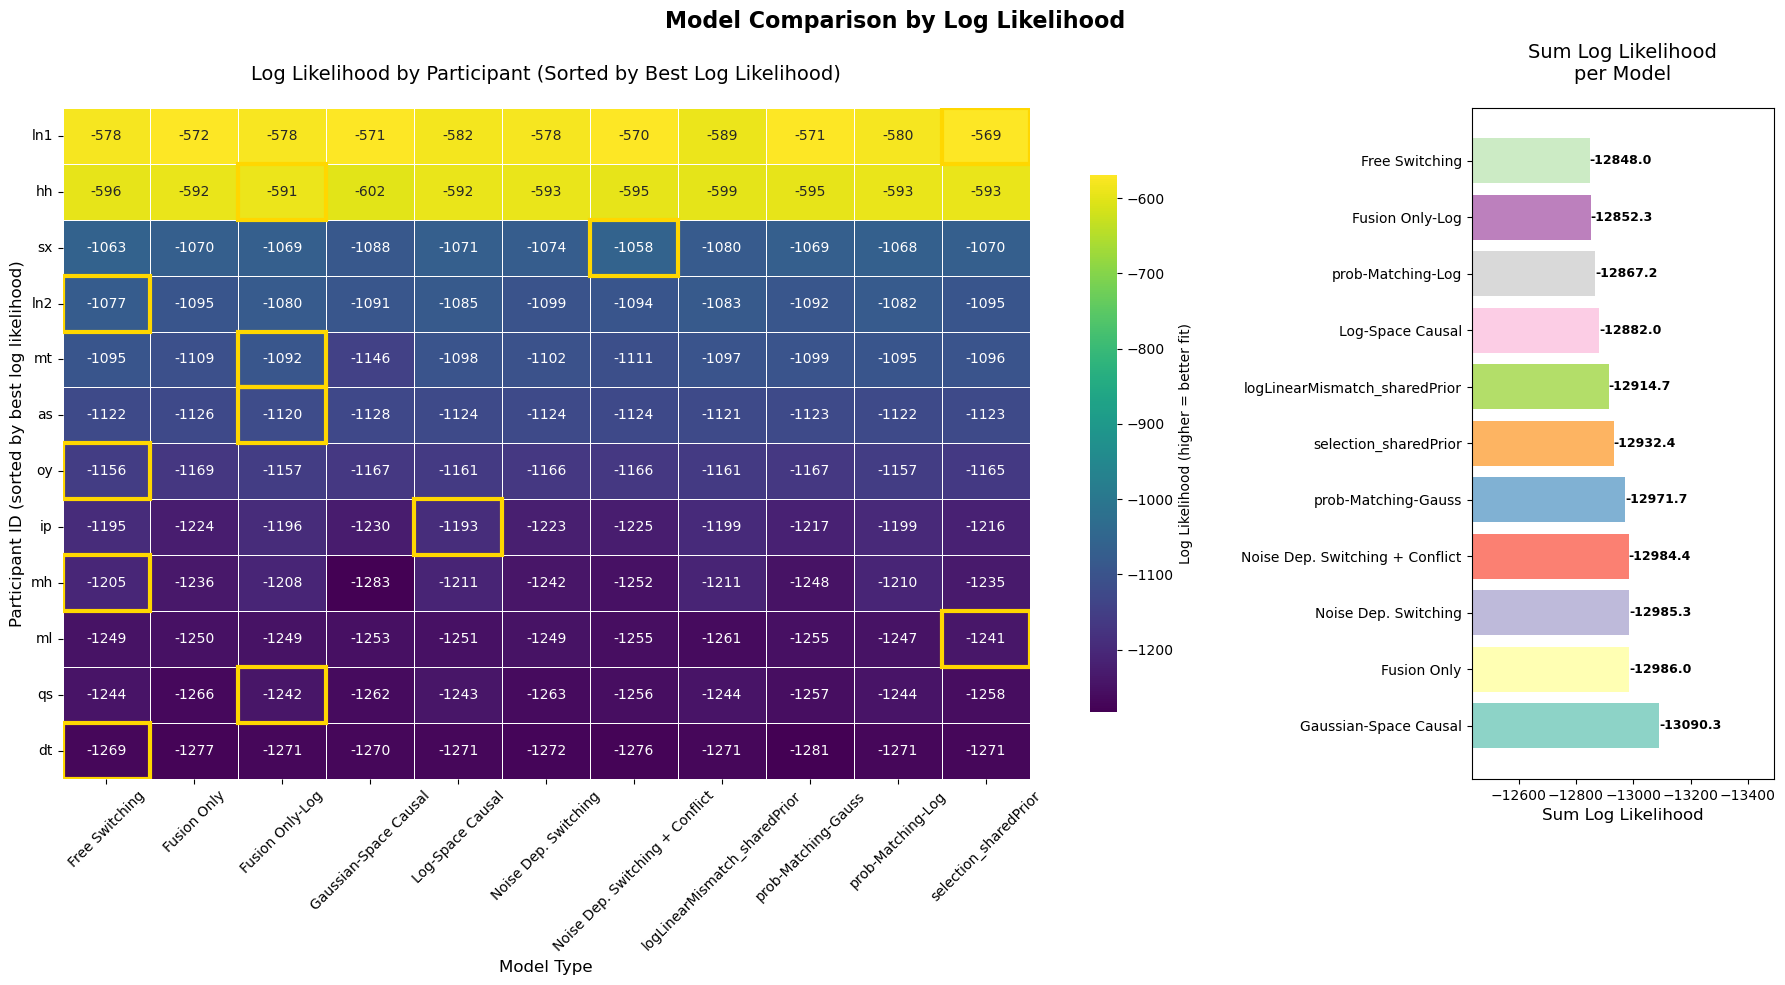


PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)
Rank Participant  Best LL    Best Model         Sum ΔAIC   Performance    
------------------------------------------------------------------------------------------
1    ln1          -569       selection_sharedPrior 158.0      Excellent fit  
2    hh           -591       Fusion Only-Log    100.9      Excellent fit  
3    sx           -1058      Noise Dep. Switching + Conflict 227.3      Moderate fit   
4    ln2          -1077      Free Switching     235.9      Moderate fit   
5    mt           -1092      Fusion Only-Log    291.2      Moderate fit   
6    as           -1120      Fusion Only-Log    92.9       Moderate fit   
7    oy           -1156      Free Switching     163.4      Moderate fit   
8    ip           -1193      Log-Space Causal   391.4      Moderate fit   
9    mh           -1205      Free Switching     557.3      Poor fit       
10   ml           -1241      selection_sharedPrior 231.2      Poor fit       
11   q

In [9]:
# Plot Log Likelihood Comparison Table (similar to ΔAIC visualization)
import matplotlib.pyplot as plt
import seaborn as sns


def plot_log_likelihood_comparison_table(df_results):
    """Create a comprehensive log likelihood comparison plot similar to ΔAIC visualization"""
    
    # Sort participants by their best (highest) log likelihood values
    participant_best_ll = df_results.groupby('participantID')['logLikelihood'].max().sort_values(ascending=False)
    sorted_participants = participant_best_ll.index.tolist()
    
    # Create the pivot table with sorted participants for log likelihoods
    df_log_likelihood = df_results.pivot(index='participantID', columns='modelType', values='logLikelihood')
    df_log_likelihood = df_log_likelihood.reindex(sorted_participants)
    
    # Find best model for each participant (highest log likelihood)
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by Log Likelihood', fontsize=16, fontweight='bold')
    
    # Main heatmap with log likelihood values
    sns.heatmap(df_log_likelihood, 
                annot=True, 
                fmt='.0f', 
                cmap='viridis', 
                ax=ax1,
                cbar_kws={'label': 'Log Likelihood (higher = better fit)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Log Likelihood by Participant (Sorted by Best Log Likelihood)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by best log likelihood)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators (gold borders)
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_log_likelihood.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a gold border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='gold', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Sum Log Likelihood per model - sum across rows (participants) for each model column
    sum_ll = df_log_likelihood.sum(axis=0).sort_values()  # sum across participants for each model
    colors = plt.cm.Set3(range(len(sum_ll)))
    
    bars = ax2.barh(range(len(sum_ll)), sum_ll.values, color=colors)
    ax2.set_yticks(range(len(sum_ll)))
    ax2.set_yticklabels(sum_ll.index, fontsize=10)
    ax2.set_xlabel('Sum Log Likelihood', fontsize=12)
    ax2.set_title('Sum Log Likelihood\nper Model', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, sum_ll.values)):
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                 f'{val:.1f}',
                 ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Set limits for the heatmap axes
    ax2.set_xlim(min(sum_ll.values)*0.95, max(sum_ll.values)*1.05)

    # Adjust layout
    plt.tight_layout()
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Best LL':<10} {'Best Model':<18} {'Sum ΔAIC':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data['delta_AIC'].sum()
        best_ll = participant_data['logLikelihood'].max()
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        
        if best_ll >= -600:
            performance = "Excellent fit"
        elif best_ll >= -900:
            performance = "Good fit"
        elif best_ll >= -1200:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {best_ll:<10.0f} {best_model:<18} {sum_delta_aic:<10.1f} {performance:<15}")
    
    return df_log_likelihood, best_models
# ...existing code...

    return df_log_likelihood, best_models

# Create the enhanced log likelihood visualization
ll_table, ll_best_models = plot_log_likelihood_comparison_table(df_results)

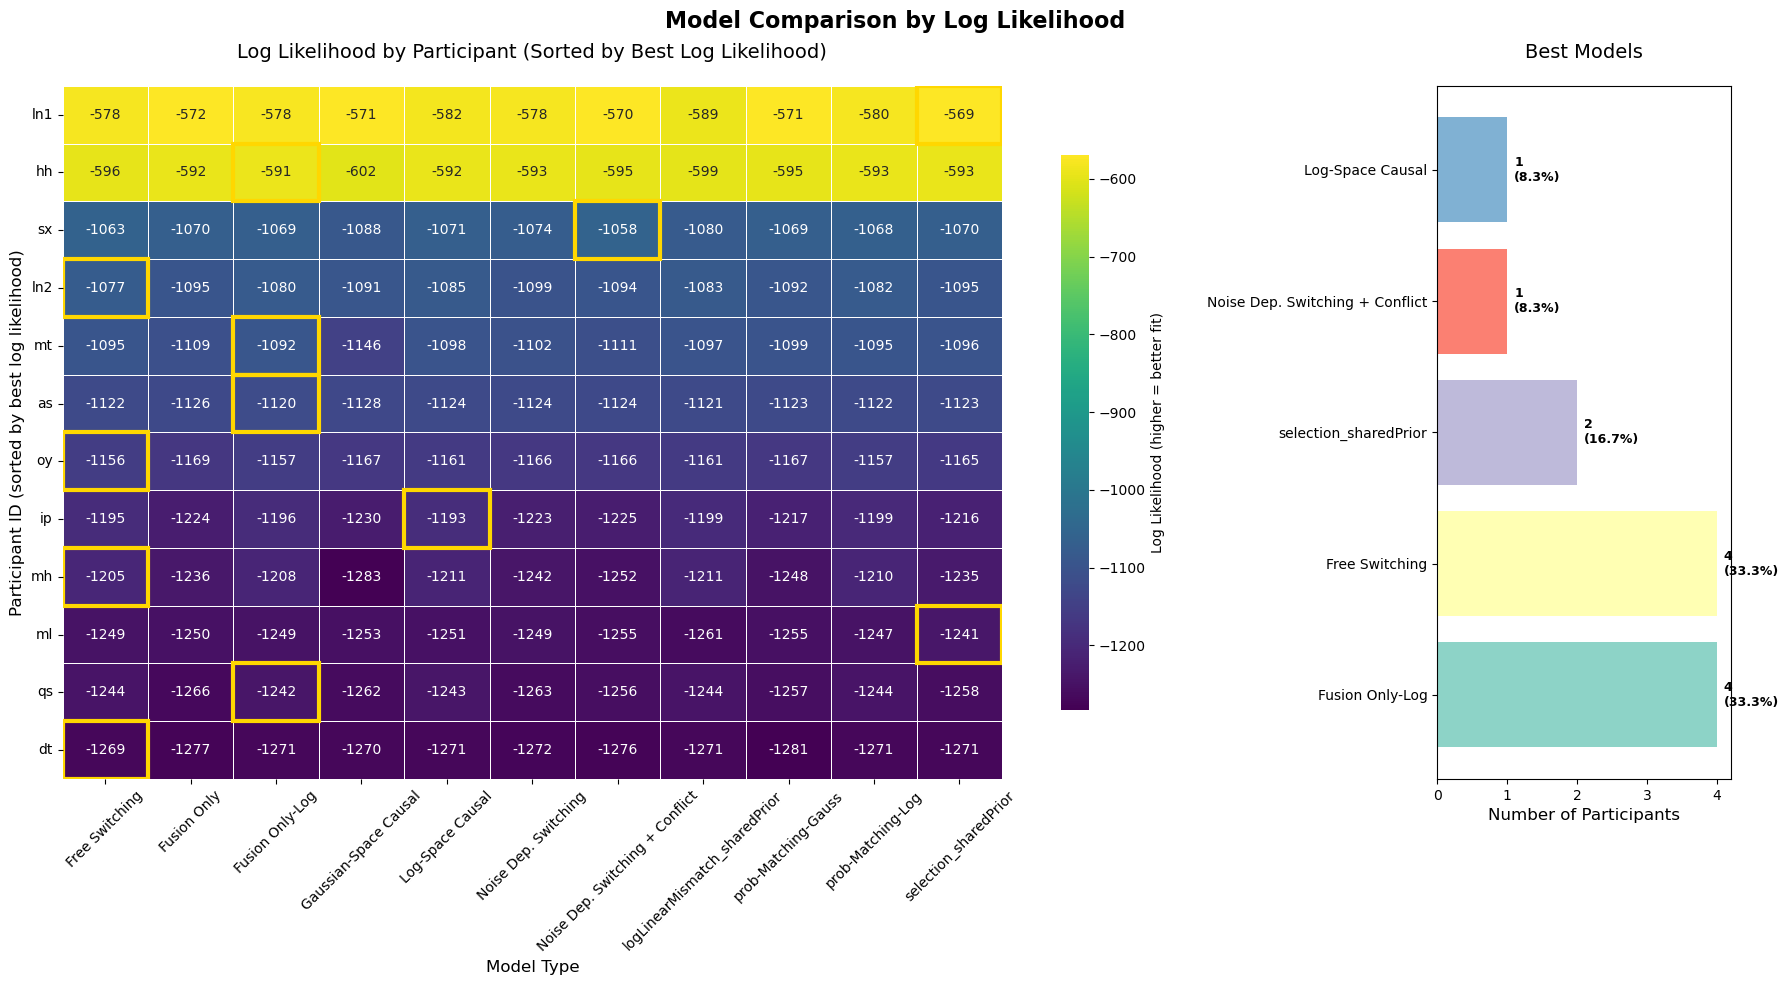


PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)
Rank Participant  Best LL    Best Model         Sum ΔAIC   Performance    
------------------------------------------------------------------------------------------
1    ln1          -569       selection_sharedPrior 158.0      Excellent fit  
2    hh           -591       Fusion Only-Log    100.9      Excellent fit  
3    sx           -1058      Noise Dep. Switching + Conflict 227.3      Moderate fit   
4    ln2          -1077      Free Switching     235.9      Moderate fit   
5    mt           -1092      Fusion Only-Log    291.2      Moderate fit   
6    as           -1120      Fusion Only-Log    92.9       Moderate fit   
7    oy           -1156      Free Switching     163.4      Moderate fit   
8    ip           -1193      Log-Space Causal   391.4      Moderate fit   
9    mh           -1205      Free Switching     557.3      Poor fit       
10   ml           -1241      selection_sharedPrior 231.2      Poor fit       
11   q

In [10]:
# Plot Log Likelihood Comparison Table (similar to ΔAIC visualization)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_log_likelihood_comparison_table(df_results):
    """Create a comprehensive log likelihood comparison plot similar to ΔAIC visualization"""
    
    # Sort participants by their best (highest) log likelihood values
    participant_best_ll = df_results.groupby('participantID')['logLikelihood'].max().sort_values(ascending=False)
    sorted_participants = participant_best_ll.index.tolist()
    
    # Create the pivot table with sorted participants for log likelihoods
    df_log_likelihood = df_results.pivot(index='participantID', columns='modelType', values='logLikelihood')
    df_log_likelihood = df_log_likelihood.reindex(sorted_participants)
    
    # Find best model for each participant (highest log likelihood)
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by Log Likelihood', fontsize=16, fontweight='bold')
    
    # Main heatmap with log likelihood values
    sns.heatmap(df_log_likelihood, 
                annot=True, 
                fmt='.0f', 
                cmap='viridis', 
                ax=ax1,
                cbar_kws={'label': 'Log Likelihood (higher = better fit)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Log Likelihood by Participant (Sorted by Best Log Likelihood)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by best log likelihood)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators (gold borders)
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_log_likelihood.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a gold border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='gold', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Best model summary
    
    best_model_counts = pd.Series(best_models).value_counts()
    colors = plt.cm.Set3(range(len(best_model_counts)))
    
    bars = ax2.barh(range(len(best_model_counts)), best_model_counts.values, color=colors)
    ax2.set_yticks(range(len(best_model_counts)))
    ax2.set_yticklabels(best_model_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Participants', fontsize=12)
    ax2.set_title('Best Models', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, best_model_counts.values)):
        percentage = (count / len(sorted_participants)) * 100
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{count}\n({percentage:.1f}%)', 
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Best LL':<10} {'Best Model':<18} {'Sum ΔAIC':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data['delta_AIC'].sum()
        best_ll = participant_data['logLikelihood'].max()
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        
        if best_ll >= -600:
            performance = "Excellent fit"
        elif best_ll >= -900:
            performance = "Good fit"
        elif best_ll >= -1200:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {best_ll:<10.0f} {best_model:<18} {sum_delta_aic:<10.1f} {performance:<15}")
    
    return df_log_likelihood, best_models

# Create the enhanced log likelihood visualization
ll_table, ll_best_models = plot_log_likelihood_comparison_table(df_results)

In [11]:
df_results

,participantID,modelType,fittedParams,AIC,BIC,logLikelihood,n_conditions,nParameters,AIC_recalculated,delta_AIC
0,sx,Free Switching,"[0.0010000761032104288, 0.0684153325366973, 0....",2141.076250,2175.526452,-1062.538125,548,8,2141.076250,5.594516
1,sx,Log-Space Causal,"[0.010827709444374759, 0.2970975477012458, 0.3...",2155.071194,2185.215121,-1070.535597,548,7,2155.071194,19.589460
2,sx,logLinearMismatch_sharedPrior,"[0.032859806000393364, 0.2476851209303061, 0.2...",2173.184572,2203.328499,-1079.592286,548,7,2173.184572,37.702838
3,sx,Fusion Only,"[0.022887993079794316, 0.153758934479332, 0.16...",2152.265325,2177.811330,-1070.132662,522,6,2152.265325,16.783591
4,sx,Fusion Only-Log,"[0.001000086629595498, 0.30521380870952497, 0....",2149.645484,2175.483135,-1068.822742,548,6,2149.645484,14.163750
...,...,...,...,...,...,...,...,...,...,...
127,ip,Noise Dep. Switching,"[0.27314112638435994, 0.10224985842073724, 0.2...",2463.951618,2501.756200,-1222.975809,493,9,2463.951618,63.189809
128,ip,Gaussian-Space Causal,"[0.18700045776458166, 0.13105093065150072, 0.2...",2473.681472,2503.085036,-1229.840736,493,7,2473.681472,72.919663
129,ip,logLinearMismatch_sharedPrior,"[0.1911488932291989, 0.19594522194790084, 0.89...",2412.412694,2441.816258,-1199.206347,493,7,2412.412694,11.650885
130,ip,Fusion Only-Log,"[0.13788956496247556, 0.23585898570927377, 1.1...",2404.078456,2429.281511,-1196.039228,493,6,2404.078456,3.316648


In [12]:
participantIDs= sorted(df_results['participantID'].unique())
modelTypes= sorted(df_results['modelType'].unique())
tMaxArr=[]
tMinArr=[]
for pid in participantIDs:
    participant_data = df_results[df_results['participantID'] == pid]
    pid_lognorm_fit = participant_data[participant_data['modelType'] == 'Log-Space Causal']
    tMinFit = pid_lognorm_fit['fittedParams'].values[0][-2]
    tMaxFit = pid_lognorm_fit['fittedParams'].values[0][-1]    
    print(f"Participant {pid}: tMinFit={tMinFit}, tMaxFit={tMaxFit}")
    tMaxArr.append(tMaxFit)
    tMinArr.append(tMinFit)



Participant as: tMinFit=0.12421681764623521, tMaxFit=0.06750085093685042
Participant dt: tMinFit=0.24282715999524446, tMaxFit=0.17474875858411432
Participant hh: tMinFit=0.011698662504131733, tMaxFit=0.046276573618942
Participant ip: tMinFit=0.1634607958550764, tMaxFit=0.0014171482443643465
Participant ln1: tMinFit=0.10420228430947126, tMaxFit=0.08897605120443203
Participant ln2: tMinFit=0.027689885372318698, tMaxFit=0.10101191201039958
Participant mh: tMinFit=0.016567829586097038, tMaxFit=0.2518543872668961
Participant ml: tMinFit=0.0346515542267517, tMaxFit=0.20576352538150047
Participant mt: tMinFit=0.11110506710948628, tMaxFit=0.25785483088985534
Participant oy: tMinFit=0.053903223327151015, tMaxFit=0.1439481606872105
Participant qs: tMinFit=0.14499010003122176, tMaxFit=0.16358610202980436
Participant sx: tMinFit=0.1140800001175444, tMaxFit=0.17731227541257222


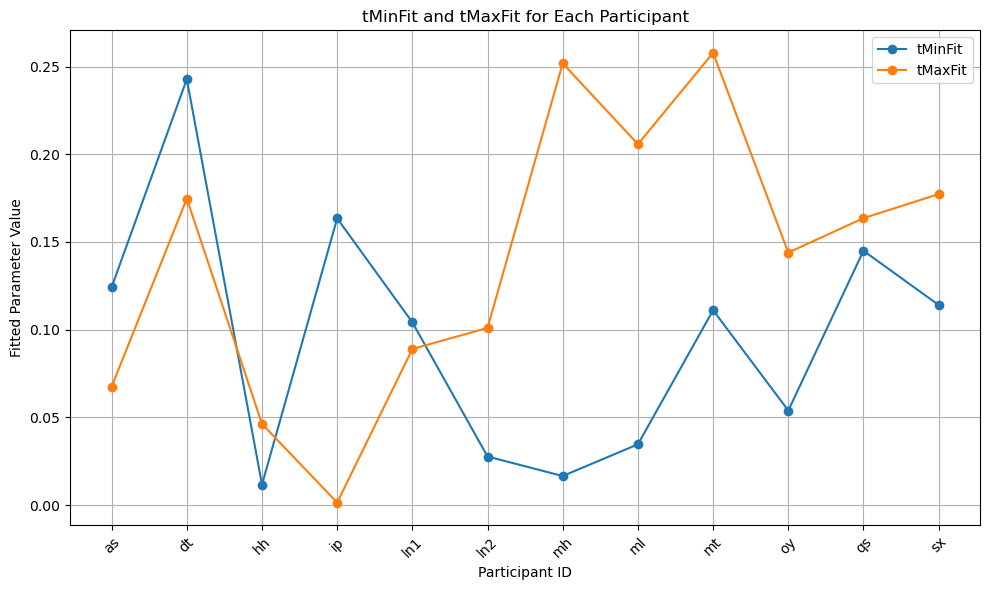

In [13]:
# Plot tMinArr and tMaxArr
plt.figure(figsize=(10, 6))
plt.plot(participantIDs, tMinArr, label='tMinFit', marker='o')
plt.plot(participantIDs, tMaxArr, label='tMaxFit', marker='o')

# Add labels, title, and legend
plt.xlabel('Participant ID')
plt.ylabel('Fitted Parameter Value')
plt.title('tMinFit and tMaxFit for Each Participant')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()